## Comparing CEDS and SNEII inventories in OsloCTM3
### Surface ozone

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
#import xesmf as xe
from matplotlib import rcParams
import pandas as pd
import regionmask
import geopandas as gp
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
import matplotlib

ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db


In [2]:
#define file locations
file_loc1 = '/div/pdo/mariantl/QUISARC/osloctm3_newIndEmis/dta2nc/'
#file_loc2 = '/div/pdo/mariantl/ACACIA_AVIATE/input4rf/kernels/'

#***change filename here***
filename1 = 'OsloCTM3_conc_load3d_monthly_2018_CEDS21.nc'
filename2 = 'OsloCTM3_conc_load3d_monthly_2018_CEDS_SNEII_merged.nc'

outfile = '/div/nac/users/zofias/plots/SNEII/'

In [3]:
rcParams['font.size'] = 16

time_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] #[1,2,3,4,5,6,7,8,9,10,11,12]
month_labs = ['J','F','M','A','M','J','J','A','S','O','N','D']

### Import data

In [4]:
#import data
ds_ceds = xr.open_dataset(f'{file_loc1}{filename1}')
ds_sneii = xr.open_dataset(f'{file_loc1}{filename2}')

#calculate difference
ds_diff = ds_sneii - ds_ceds

In [5]:
#import area dataset for area weighted mean
#ds_area = xr.open_dataset('/div/nac/users/zofias/ACACIA/OsloCTM3_80_160_areacella.nc')
ds_delta_z = xr.open_dataset('/div/nac/users/zofias/ACACIA/OsloCTM3_80_160_delta_z.nc')

box_area = ds_ceds["area"]
delta_z = ds_delta_z["delta_z"]*-1

ds_landmask = xr.open_dataset('/div/no-backup/users/zofias/landsea_OsloCTMres.nc')

ds_landmask['lat'] = ds_sneii.lat
ds_landmask['lon'] = ds_sneii.lon


weights_lat_lon_3d = np.array(60*[box_area.data]) # weights for 12 months
#weights_lat_lon_2d = box_area.data

### Calculations: averaging, surface conc, column

In [6]:
calcs = {
    "CEDS": xr.Dataset(),
    "diff": xr.Dataset(),
    "SNEII": xr.Dataset()
}

models = {
    "CEDS": ds_ceds,
    "diff": ds_diff,
    "SNEII": ds_sneii
}

model_list = ["CEDS", "diff", "SNEII"]

In [7]:
mr_o3 = 48
mr_air = 28.97
n_a = 6.022e23

In [8]:
#select surface conc and calculate mean
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")
    
    exp_calc["O3_surf"] = (
        exp_ukca.O3 
        .isel(lev = 0)
        *1e9 #convert to ppb
    )

In [9]:
#land mask
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")
    
    exp_calc["O3_land_masked"] = (
        exp_calc.O3_surf.where(ds_landmask.LSMASK > 0.9)
        .load()
    )

In [10]:
#select surface conc and calculate mean
for exp in model_list:
    exp_calc = calcs[exp]
    
    exp_calc["O3_india_land_mean"] = (
        exp_calc["O3_land_masked"]
        .sel(lon=slice(65, 95), lat=slice(5, 35))
        .weighted(box_area)
        .mean(dim=('lat','lon'))
        .load()
    )

### Plots

In [11]:
cmap_ol_pu_bk = LinearSegmentedColormap.from_list('Random gradient 442', (
    # Edit this gradient at https://eltos.github.io/gradient/#Random%20gradient%20442=0:FFFFFF-25:B6B610-60:7A7AF3-100:000000
    (0.000, (1.000, 1.000, 1.000)),
    (0.250, (0.714, 0.714, 0.063)),
    (0.600, (0.478, 0.478, 0.953)),
    (1.000, (0.000, 0.000, 0.000))))

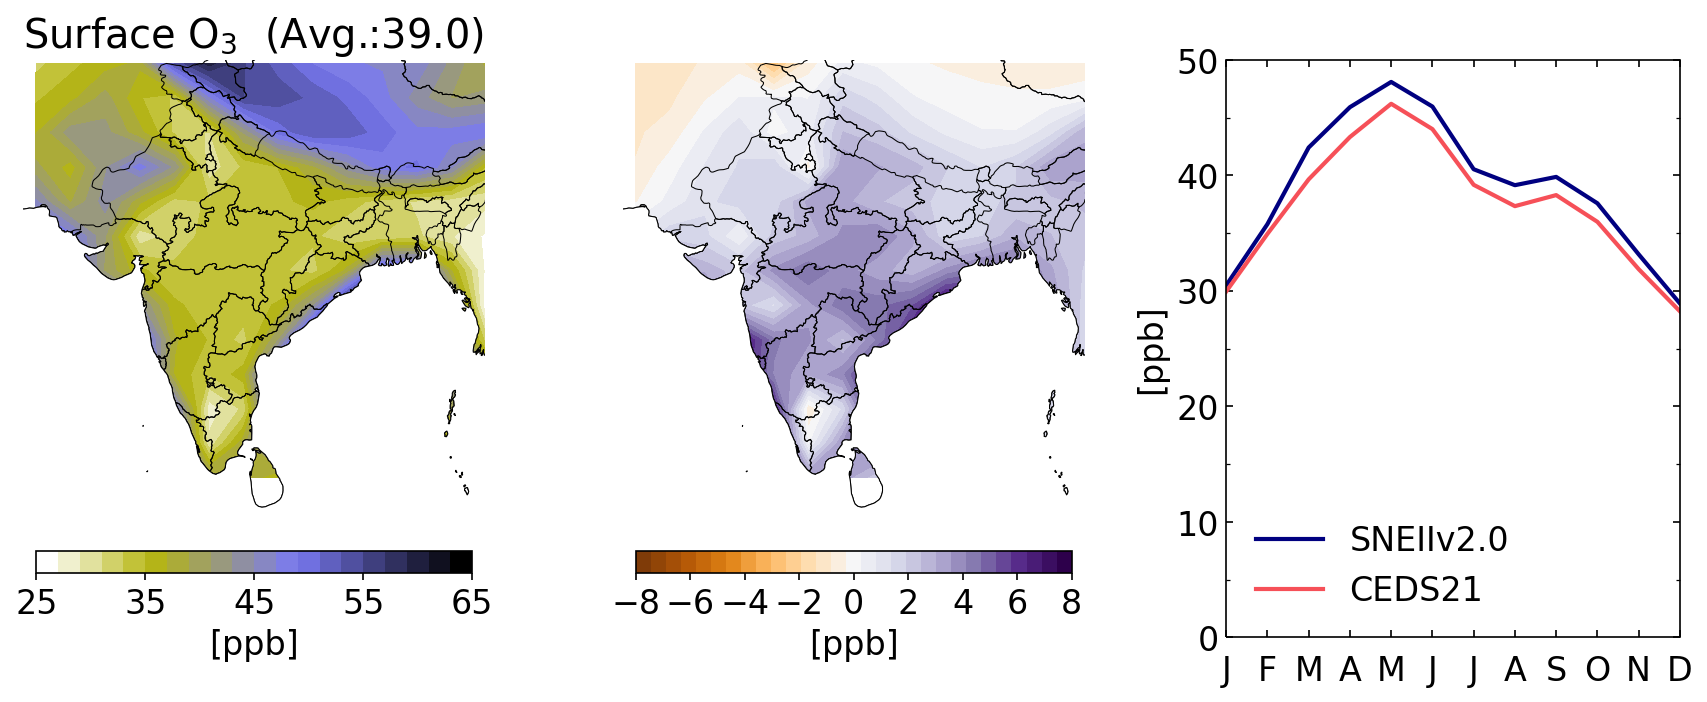

In [12]:
fig, axs = plt.subplots(1, 3, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(15, 5))


# Ammonium
ax = axs[0]
fg1 = calcs['SNEII'].O3_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap=cmap_ol_pu_bk, vmax=65, vmin=25,
    levels=21, add_colorbar=False
)
cbar1 = fig.colorbar(fg1, ax=ax, label=r"[ppb]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(25, 66,10))
cbar1.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_title('')
ax.set_title(f"Surface O$_3$  (Avg.:{calcs['SNEII'].O3_india_land_mean.mean():.1f})", loc='left')
#ax.set_title(f"(Avg.:{calcs['SNEII'].NH4_india_land_mean.mean():.1f})", loc='right')
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
#ax.set_title(f"e)  Ammonium (Avg.:{calcs['SNEII'].NH4_india_land_mean.mean():.1f})")
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")


# Plot 2: Difference map
ax = axs[1]
fg2 = calcs['diff'].O3_surf.mean(dim='time').sel(lon=slice(65, 96), lat=slice(6, 35)).plot.contourf(
    ax=ax, cmap="PuOr", vmax=8, vmin=-8, 
    levels=30, add_colorbar=False
)
cbar2 = fig.colorbar(fg2, ax=ax, label=r"[ppb]", location='bottom', pad=0.05, shrink=0.8, ticks=np.arange(-8, 8.1, 2))
cbar2.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k', linewidth=0.5, facecolor='w')
ax.set_title('')
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
ax.axis("off")

ax = axs[2]
calcs['SNEII'].O3_india_land_mean.plot(ax=ax, label = 'SNEIIv2.0', c= (0,0,128/255),linewidth=2)
calcs['CEDS'].O3_india_land_mean.plot(ax=ax, label = 'CEDS21', c=(246/255,80/255,88/255),linewidth=2)

# chart formatting
ax.set_xlim(0,11)
#ax.set_ylim(0,6)
ax.set_xticks(calcs['CEDS'].O3_india_land_mean.time.data)
ax.set_xticklabels(month_labs)
ax.set_xlabel('')
ax.set_ylabel(r"[ppb]")
ax.set_title('')
ax.set_yticks(np.arange(0,51,10))
leg = plt.legend(frameon=False)
ax.xaxis.set_tick_params(direction='in', which='both',top=True,pad=8)
ax.yaxis.set_tick_params(direction='in', which='both',right=True)
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_aspect(0.28)

#plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig(f'{outfile}Fig3_o3_surf_SNEII_diff_landmean.pdf',format='pdf',bbox_inches='tight')